In [25]:
import sys
import platform
import torch
import pandas as pd
import numpy as np
import sklearn as sk
from datasets import load_dataset, load_metric, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Uncomment only for colab
# from google.colab import drive
# drive.mount('/content/drive')

In [26]:
# check hardware availability
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()

device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.5-arm64-arm-64bit
PyTorch Version: 2.1.0.dev20230902

Python 3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:53:08) 
[Clang 15.0.7 ]
Pandas 2.1.0
Scikit-Learn 1.3.0
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


/var/folders/rz/hqy45d3569g71gtmcbpt6vkr0000gp/T/ipykernel_1955/82983826.py:5: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch,'has_mps',False) \


## Dataset loading

In [61]:
def score_sentiment_multiclass(x):
  if x == "positive":
    return 0

  if x == "negative":
    return 1

  if x == "neutral":
    return 2

def score_sentiment_binary(x):
  if x == "negative" or x == "neutral":
    return 0 
  else:
    return 1


# change location if running on colab
file_name = "pos_labeled_data.csv"
df_pred = pd.read_csv(file_name)
df_pred["target"] = df_pred["label"].apply(score_sentiment_multiclass)
df_pred["target_inv"] = 2 - df_pred["target"] 

n_samples = 8000

# load Dataset from Pandas DataFrame
dataset = Dataset.from_pandas(df_pred[["clean_message", "target", "sentiment","id"]].iloc[:n_samples])
ds = dataset.train_test_split()

/Users/camilo.ramirez/miniconda3/envs/torch/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


## Inference with pretrained transformer

In [62]:
# Load tokenizer and model, create trainer

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score,
  precision_score,
  recall_score,
  f1_score,
  confusion_matrix,
  ConfusionMatrixDisplay)


def preprocess_function(examples):
    return tokenizer(examples["clean_message"], padding="max_length", truncation=True)


def compute_metrics(model, dataloader, device):
    predictions = None
    references = None
    model.eval()
    print(f"running inference on {device.type}")
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits

        if predictions is None:
            predictions = torch.argmax(logits, dim=-1)
            references = batch["labels"]
        else:
            predictions = torch.cat((predictions, torch.argmax(logits, dim=-1)))
            references = torch.cat((references, batch["labels"]))
    
    return predictions, references

def report_metrics(y_pred, y_true):

  # Accuracy
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)

  # Precision
  precision = precision_score(y_true, y_pred, average="weighted")
  print("Precision:", precision)

  # Recall (Sensitivity)
  recall = recall_score(y_true, y_pred, average="weighted")
  print("Recall:", recall)

  # F1-score
  f1 = f1_score(y_true, y_pred, average="weighted")
  print("F1 Score:", f1)

  # Confusion Matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  disp = ConfusionMatrixDisplay(conf_matrix)
  disp.plot()

  plt.show()

In [64]:
from torch.utils.data import DataLoader

test_dataset = ds["test"].map(preprocess_function, batched=True)
test_dataset = test_dataset.remove_columns(["clean_message", "sentiment", "id"])
test_dataset = test_dataset.rename_column("target", "labels")
test_dataset.set_format("torch")

test_dataloader = DataLoader(test_dataset, batch_size=8)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

running inference on mps
Accuracy: 0.619
Precision: 0.6657933882354528
Recall: 0.619
F1 Score: 0.5336805713851202


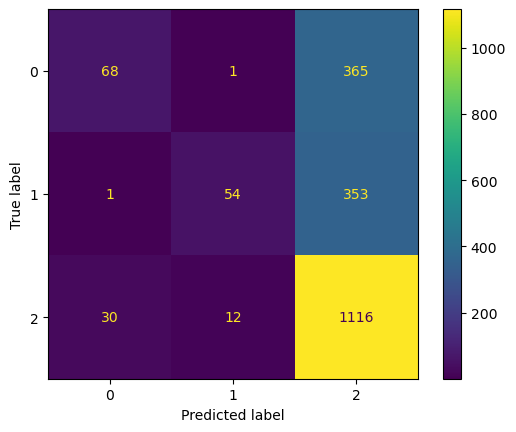

In [65]:
# in case device was used before
torch.mps.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
finbert_model.to(device)

predictions, references = compute_metrics(model=finbert_model, dataloader=test_dataloader, device=device)
pred_np = predictions.cpu().numpy()
ref_np = references.cpu().numpy()
report_metrics(pred_np[:], ref_np[:])


In [67]:
pd.Series(pred_np).value_counts()

2    1834
0      99
1      67
Name: count, dtype: int64

## Model fine tuning

In [68]:
model_checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
def preprocess_function(examples):
    return tokenizer(examples["clean_message"], padding="max_length", truncation=True)

encoded_dataset = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [69]:
encoded_dataset = encoded_dataset.remove_columns(["clean_message", "sentiment", "id"])
encoded_dataset = encoded_dataset.rename_column("target", "labels")
encoded_dataset.set_format("torch")

In [70]:
# DataLoaders wrapping
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_dataset["train"], shuffle=True, batch_size=8)
eval_dataloader = DataLoader(encoded_dataset["test"], batch_size=8)

### Model training

In [71]:
from transformers import AutoModelForSequenceClassification

TRAIN_MODEL = True

if not TRAIN_MODEL:
    model_name = "models/telegram_multiclass_1"
else: 
    model_name = model_checkpoint

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
# in case device was used before
torch.mps.empty_cache()

# Define optimizer
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define scheduller
from transformers import get_scheduler
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Device selection
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [74]:
# Training loop

from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/2250 [00:00<?, ?it/s]

### Metrics

running inference on mps
Accuracy: 0.7585
Precision: 0.7550578500734241
Recall: 0.7585
F1 Score: 0.7536221929205373


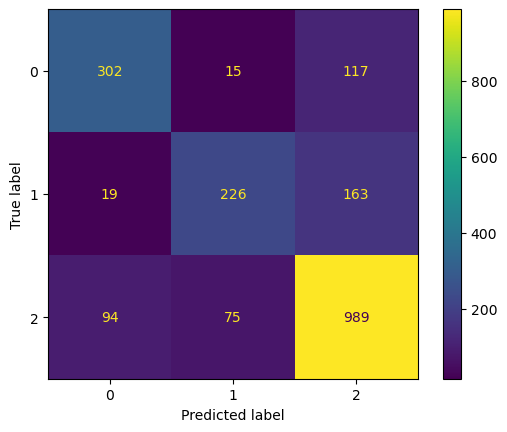

In [75]:
predictions, references = compute_metrics(model, eval_dataloader, device=device)
pred_np = predictions.cpu().numpy()
ref_np = references.cpu().numpy()
report_metrics(pred_np[:], ref_np[:])

In [85]:
pred_np[:10]

array([1, 2, 2, 1, 2, 1, 2, 1, 2, 1])

In [86]:
ref_np[:10]

array([1, 2, 2, 0, 2, 1, 2, 1, 2, 1])

In [76]:
model.save_pretrained("models/telegram_multiclass_2")